In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Custom modules
from approximators import MLP, QValueApproximator
from states import EnvironmentState
from agents import LearningAgent
from data import DataGenerator

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [2]:
n_levels = 10
horizon = 200
action_size = 10
n_episodes = 1

data = DataGenerator.generator("../data/AAPL.parquet", levels=n_levels).head(30000)

means = data[['Mid Price Movement', 'Market Spread', 'Book Imbalance', 'Signed Volume', 'Volatility', 'RSI']].mean()
means = np.concatenate([means.values, [0, 2.5, 2.5, 4.5]])

stds = data[['Mid Price Movement', 'Market Spread', 'Book Imbalance', 'Signed Volume', 'Volatility', 'RSI']].std()
stds = np.concatenate([stds.values, [1e4/3, 1.9, 1.9, 3]])

# Combine the two vectors in a matirx
std_values = np.vstack((means, stds)).T.astype(np.float32)

windows = []
for i in range(n_episodes):
    windows.append(data.iloc[i*(horizon+1):(i+1)*(horizon+1)])

In [3]:
min_values = data[['Mid Price Movement', 'Market Spread', 'Book Imbalance', 'Signed Volume', 'Volatility', 'RSI']].min().values
max_values = data[['Mid Price Movement', 'Market Spread', 'Book Imbalance', 'Signed Volume', 'Volatility', 'RSI']].max().values

min_values = np.concatenate([min_values, [-1e4, -1, -1, 0]])
max_values = np.concatenate([max_values, [1e4, 5, 5, 9]])

bounds = np.vstack((min_values, max_values)).T.astype(np.float32)

In [4]:
# model = MLP(10, 1, [64, 128, 64], torch.nn.ReLU, 0.05, device).to(device)
# q_approximator = QValueApproximator(model, 1e-4, std_values)

from approximators import TilingApproximatorMedium

q_approximator = TilingApproximatorMedium(
    bounds = bounds,
    n_tiles = 16,
    n_tilings = 64,
    # We can sample random shifts for each dimension
    shifts = np.random.uniform(0.8, 0.19, 10),
) 

In [5]:
agent = LearningAgent(
    action_size=action_size,
    q_value_approximator=q_approximator,
    epsilon=0.5,
    epsilon_decay=0.97,
    min_epsilon=0.01,
    gamma=0.99,
)

env = EnvironmentState(data, n_levels, horizon)

In [6]:
rewards_train, losses_train, bankrolls_train = [], [], []
outstanding_orders = []
inventory = []

for episode in tqdm(range(1*n_episodes)):
    episode = episode % n_episodes
    env.data = windows[episode]
    env.reset()
    rewards, losses, bankrolls = agent.train(env)

    # Track the evolution of the number of outstanding orders
    outstanding_orders.append(len(env.orders))
    inventory.append(env.inventory)
    
    rewards_train.extend(rewards)
    losses_train.extend(losses)
    bankrolls_train.extend(bankrolls)

rewards_train = pd.Series(rewards_train)
losses_train = pd.Series(losses_train)
bankrolls_train = pd.Series(bankrolls_train)
inventory = pd.Series(inventory)
outstanding_orders = pd.Series(outstanding_orders)

  0%|          | 0/1 [00:00<?, ?it/s]

Inventory out of bounds at time  10
Inventory after transactions 55
Ask transactions
 []

Bid transactions
 [(585.76, 5), (585.76, 0)]
-----
Inventary before matching orders 55
Inventory out of bounds at time  34
Inventory after transactions 55.0
Ask transactions
 []

Bid transactions
 [(586.3299999999997, 5), (586.3299999999997, 0), (586.3299999999997, 0), (586.3299999999997, 0)]
-----
Inventary before matching orders 55.0
Inventory out of bounds at time  68
Inventory after transactions 55.0
Ask transactions
 []

Bid transactions
 [(586.045, 5), (586.045, 0), (586.045, 0), (586.045, 0)]
-----
Inventary before matching orders 55.0
Inventory out of bounds at time  93
Inventory after transactions 55.0
Ask transactions
 []

Bid transactions
 [(586.125, 5), (586.125, 0), (586.125, 0), (586.125, 0), (586.125, 0), (586.125, 0), (586.125, 0)]
-----
Inventary before matching orders 55.0
Inventory out of bounds at time  98
Inventory after transactions 55.0
Ask transactions
 []

Bid transactions

<Axes: >

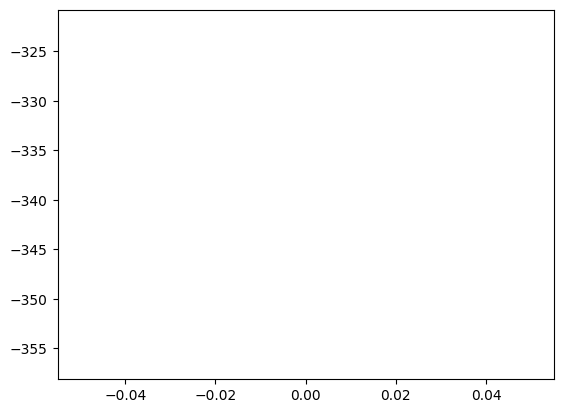

In [7]:
rewards_train.rolling(1).mean().plot()

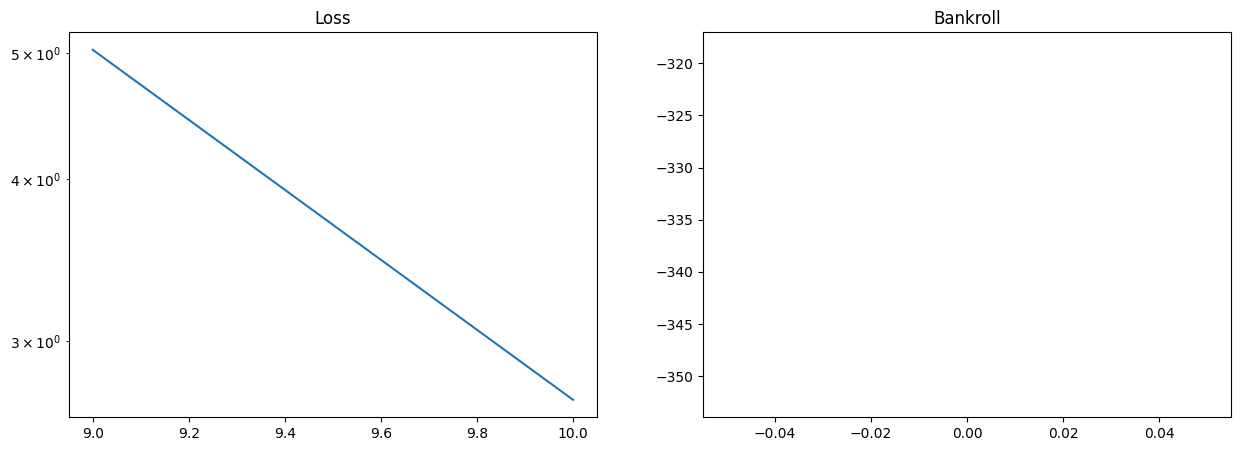

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(losses_train.rolling(10).mean())
ax[0].set_title("Loss")
ax[0].set_yscale("log")
ax[1].plot(bankrolls_train.rolling(1).mean())
ax[1].set_title("Bankroll")

plt.show()

<Axes: >

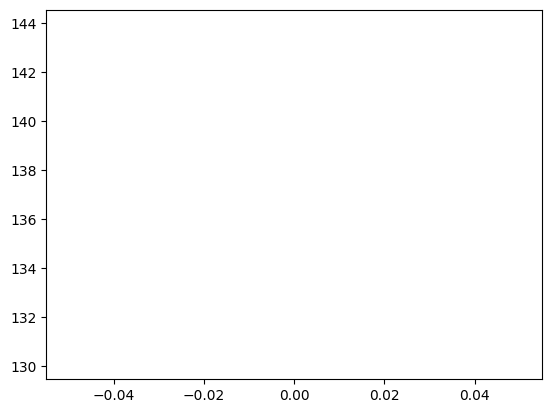

In [9]:
outstanding_orders.rolling(1).mean().plot()

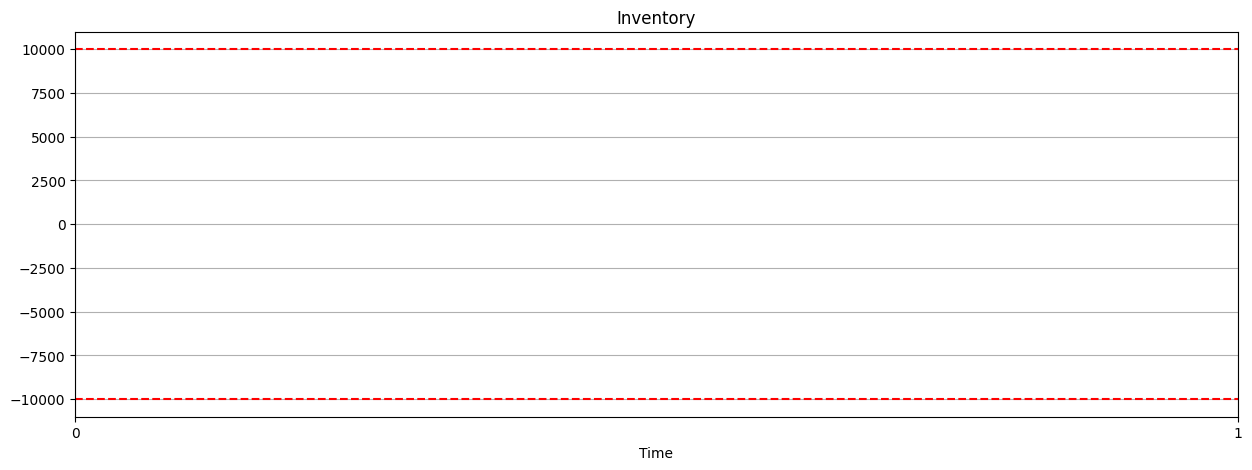

In [10]:
# Plot the inventory
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(inventory)
ax.set_title("Inventory")
ax.set_xlabel("Time")
# Set grid
ax.grid(True)
# Set x ticks every unit
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
# Set xlim
ax.set_xlim([0, len(inventory)])
# Add upper and lower bounds
ax.axhline(1e4, color='r', linestyle='--')
ax.axhline(-1e4, color='r', linestyle='--')
plt.show()
